In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

future_days = input("Please enter number of future days to predict :")
future_days = int(future_days)
#print(dir(keras.losses))

#Data import.

#data = pd.read_csv("short.csv",index_col='date', parse_dates=True)
#data = pd.read_csv("2021_2022.csv", index_col=0, parse_dates=True, header=None)
data = pd.read_csv("2021_2022.csv", index_col=0, parse_dates=True)
data = data.astype('float')
print(data.head())
datelist_train = list(data.index)
print(len(data))
#data.drop('out', axis='columns', inplace=True)
#data.plot()
#data2.plot()

Please enter number of future days to predict :10
                    Open          High           Low         Close  \
Date                                                                 
2021-04-18  60701.886719  61057.457031  52829.535156  56216.183594   
2021-04-19  56191.585938  57520.054688  54368.593750  55724.265625   
2021-04-20  55681.792969  57062.148438  53448.046875  56473.031250   
2021-04-21  56471.128906  56757.972656  53695.468750  53906.089844   
2021-04-22  53857.105469  55410.230469  50583.812500  51762.273438   

               Adj Close        Volume  
Date                                    
2021-04-18  56216.183594  9.746887e+10  
2021-04-19  55724.265625  6.534487e+10  
2021-04-20  56473.031250  6.784932e+10  
2021-04-21  53906.089844  5.492661e+10  
2021-04-22  51762.273438  7.479863e+10  
366


In [6]:
#Scale data to a range of -1,1 and split to training and testing set.
scaler = StandardScaler()
scaler = scaler.fit(data)
dataset = scaler.transform(data)
train_data = int(len(dataset) * 0.9)
test_data = (int(len(dataset) - train_data ))
train, test = dataset[0:train_data], dataset[train_data:len(dataset)]



In [7]:
# Reshape data to lenght, timesteps and number of features.
n_future = 1 
n_past = 14 
def create_dataset(my_data, n_future, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(my_data) - n_future +1):
        dataX.append(my_data[i - n_past:i, 0:my_data.shape[1]])
        dataY.append(my_data[i + n_future - 1:i + n_future, 0])
    return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(train, n_future, n_past)
testX, testY = create_dataset(test, n_future, n_past)
print(trainX.shape)
print(trainY.shape)

(315, 14, 6)
(315, 1)


In [8]:
#RNN model  starts.
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=5,validation_split=0.1, batch_size=3)
model.summary()

Epoch 1/5
95/95 [==============================] - 4s 16ms/step - loss: 0.2641 - val_loss: 0.0977
Epoch 2/5
95/95 [==============================] - 1s 16ms/step - loss: 0.1427 - val_loss: 0.0852
Epoch 3/5
95/95 [==============================] - 1s 15ms/step - loss: 0.1147 - val_loss: 0.0502
Epoch 4/5
95/95 [==============================] - 1s 13ms/step - loss: 0.0807 - val_loss: 0.0428
Epoch 5/5
95/95 [==============================] - 1s 13ms/step - loss: 0.0824 - val_loss: 0.0321
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            18176     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                          

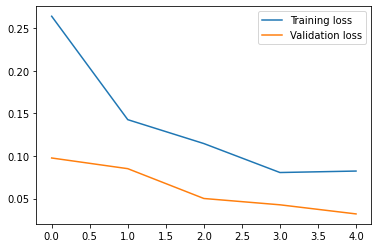

In [9]:
# Plot model loss comparison.
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
# Create future date list.
future_prediction_real = future_days
datelist_future = pd.date_range(datelist_train[-1], periods=future_prediction_real, freq='1d').tolist()

In [11]:
# Predict future days.
prediction = model.predict(trainX[-future_prediction_real:])
print(prediction.shape)
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

(10, 1)


In [12]:
# Create date list table and future pediction table and combine side by side.
datelist_future_ = []
for i in datelist_future:
    datelist_future_.append(i.date())

In [13]:
data_forecust = pd.DataFrame({'FutureDates':np.array(datelist_future), 'Prediction':y_pred_future})
data_forecust['FutureDates']=pd.to_datetime(data_forecust['FutureDates'])

In [14]:
print(pd.DataFrame(data_forecust))

  FutureDates    Prediction
0  2022-04-18  42434.613281
1  2022-04-19  42879.027344
2  2022-04-20  42066.394531
3  2022-04-21  41259.726562
4  2022-04-22  40385.164062
5  2022-04-23  39429.250000
6  2022-04-24  38913.140625
7  2022-04-25  39435.394531
8  2022-04-26  39620.351562
9  2022-04-27  39426.523438
